In [1]:
import pandas as pd
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values, missing_values_ratio
from plotnine import aes, geom_point, geom_ribbon, geom_segment, ggplot, labs, theme_bw
from statsmodels.tsa.stattools import acf, pacf

from config import ROOT
from src.realtime_utils import load_realtime_training_data

In [2]:
def plot_acf(ts, nlags=75, bartlett=True):
    ac_ts, ci = acf(ts, nlags=nlags, alpha=0.05, bartlett_confint=bartlett)

    df_acf = pd.DataFrame(
        {"lag": range(len(ac_ts)), "ac": ac_ts, "lower": ci[:, 0], "upper": ci[:, 1]}
    )

    df_acf.lower -= df_acf.ac
    df_acf.upper -= df_acf.ac

    p = (
        ggplot(df_acf, aes(x="lag", y="ac"))
        + geom_ribbon(
            aes(ymin="lower", ymax="upper"), color="skyblue", fill="skyblue", alpha=0.4
        )
        + theme_bw()
        + geom_point(size=0.6)
        + geom_segment(aes(x="lag", xend="lag", y=0, yend="ac"))
        + labs(x="Lag", y="Autocorrelation")
    )

    return p

In [3]:
def plot_pacf(ts, nlags=75):
    ac_ts, ci = pacf(ts, nlags=nlags, alpha=0.05)

    df_acf = pd.DataFrame(
        {"lag": range(len(ac_ts)), "ac": ac_ts, "lower": ci[:, 0], "upper": ci[:, 1]}
    )

    df_acf.lower -= df_acf.ac
    df_acf.upper -= df_acf.ac

    p = (
        ggplot(df_acf, aes(x="lag", y="ac"))
        + geom_ribbon(
            aes(ymin="lower", ymax="upper"), color="skyblue", fill="skyblue", alpha=0.4
        )
        + theme_bw()
        + geom_point(size=0.6)
        + geom_segment(aes(x="lag", xend="lag", y=0, yend="ac"))
        + labs(x="Lag", y="Partial autocorrelation")
    )

    return p

In [4]:
targets, covariates = load_realtime_training_data()

<Axes: xlabel='date'>

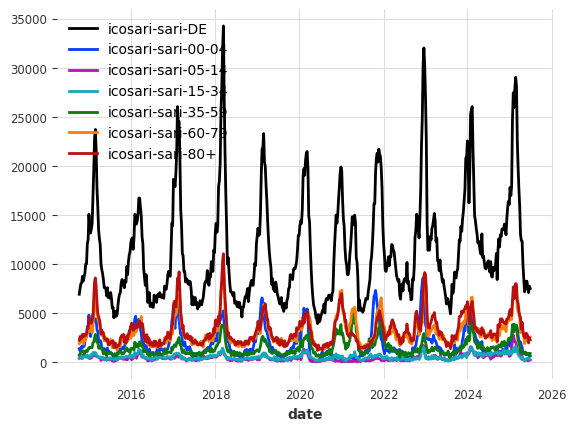

In [5]:
targets.plot()

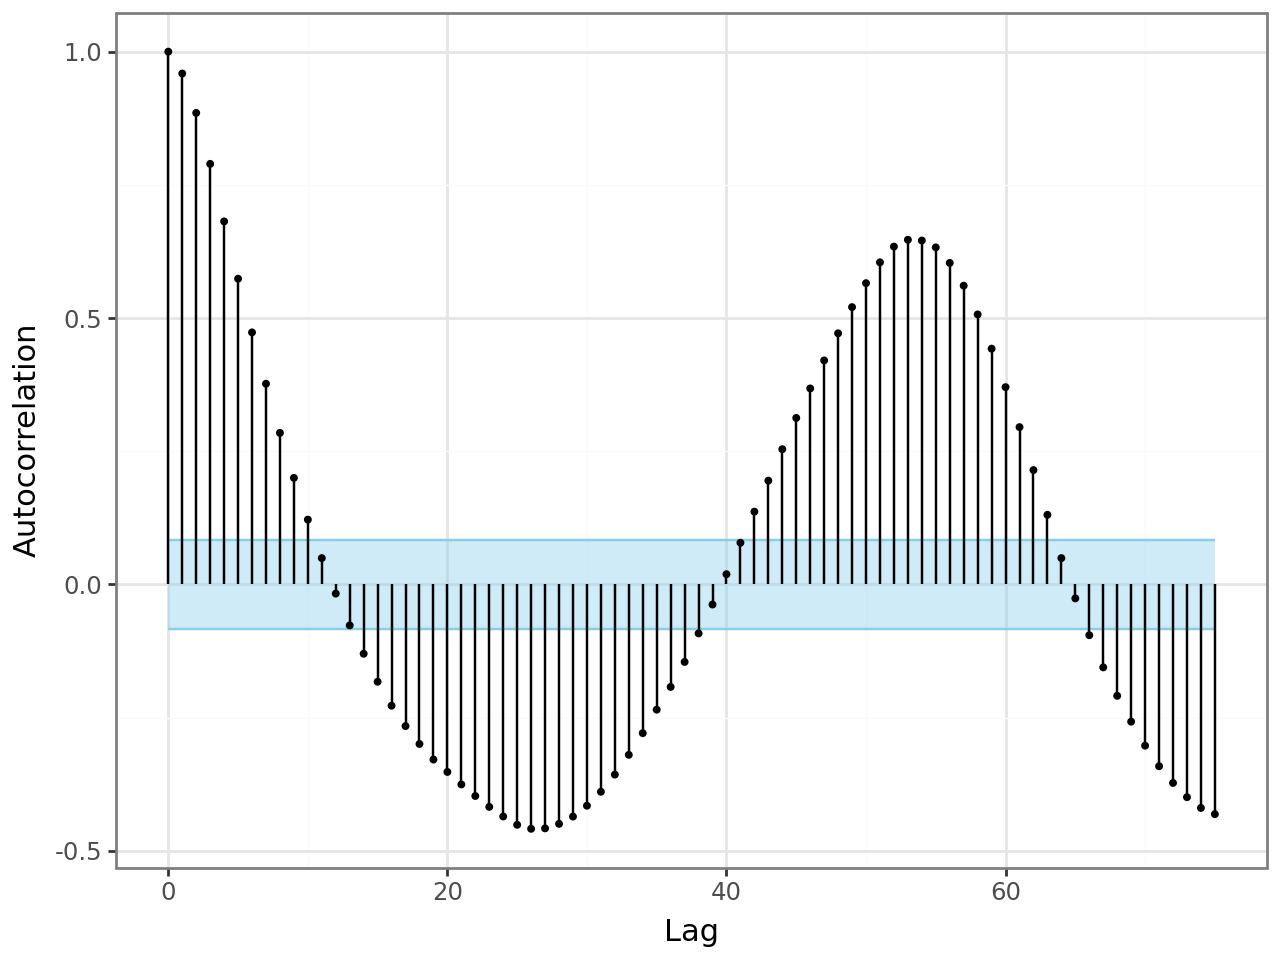

In [6]:
p = plot_acf(targets["icosari-sari-DE"].to_series(), nlags=75, bartlett=False)
p.show()

In [7]:
p.save(ROOT / "figures" / "acf.pdf", width=160, height=80, units="mm", dpi=600, verbose=False)

In [8]:
# p.save(ROOT / "figures" / "acf_bartlett.pdf", width = 160, height = 80, units="mm", dpi=600)

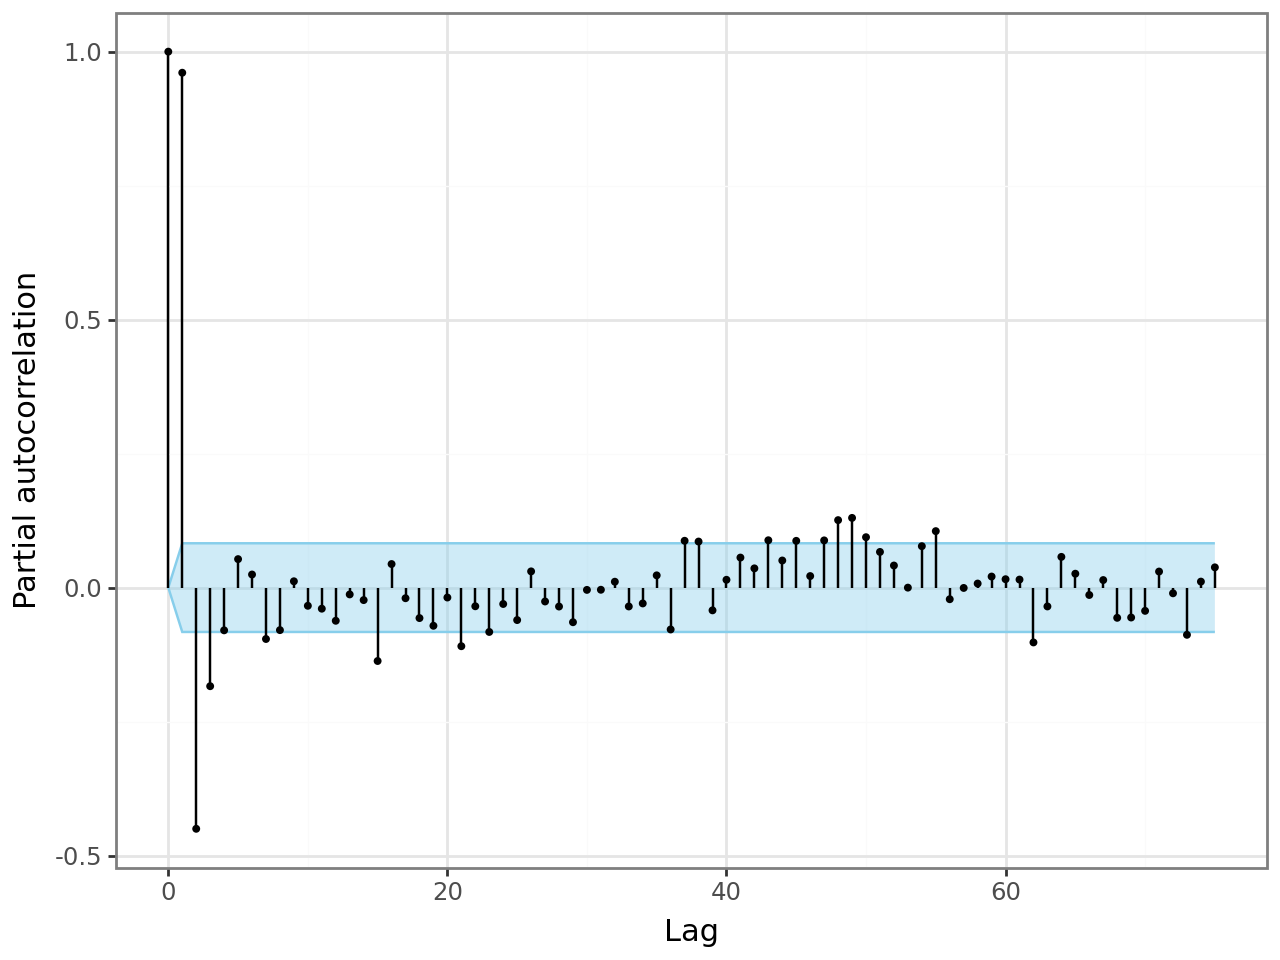

In [9]:
p = plot_pacf(targets["icosari-sari-DE"].to_series(), nlags=75)
p.show()

In [10]:
p.save(ROOT / "figures" / "pacf.pdf", width=160, height=80, units="mm", dpi=600, verbose=False)

# Remove seasonality

In [11]:
ts = targets["icosari-sari-DE"]

In [12]:
df = ts.to_dataframe()
df["week"] = df.index.isocalendar().week

adjusted = []

for idx, (t, row) in enumerate(df.iterrows()):
    current_week = row["week"]

    # Filter only past values with same week number
    past_values = df.iloc[:idx]
    past_same_week = past_values[past_values["week"] == current_week]

    if not past_same_week.empty:
        seasonal_mean = past_same_week[ts.columns[0]].mean()
        adjusted_value = row[ts.columns[0]] - seasonal_mean
    else:
        adjusted_value = None

    adjusted.append(adjusted_value)

df["deseasonalized"] = adjusted
ts_deseasonalized = TimeSeries.from_dataframe(df, value_cols="deseasonalized")

<Axes: xlabel='date'>

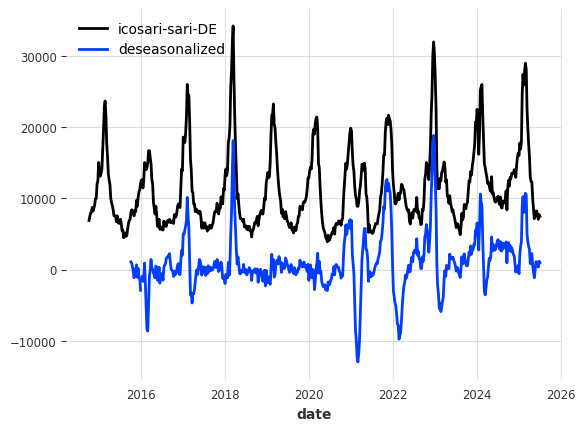

In [13]:
ts.plot()
ts_deseasonalized.plot()

In [14]:
missing_pct = missing_values_ratio(ts_deseasonalized[52:])
print(f"{missing_pct:.2%} of points are NaN")

0.20% of points are NaN


In [15]:
ts_deseasonalized = fill_missing_values(ts_deseasonalized[52:], fill="auto")

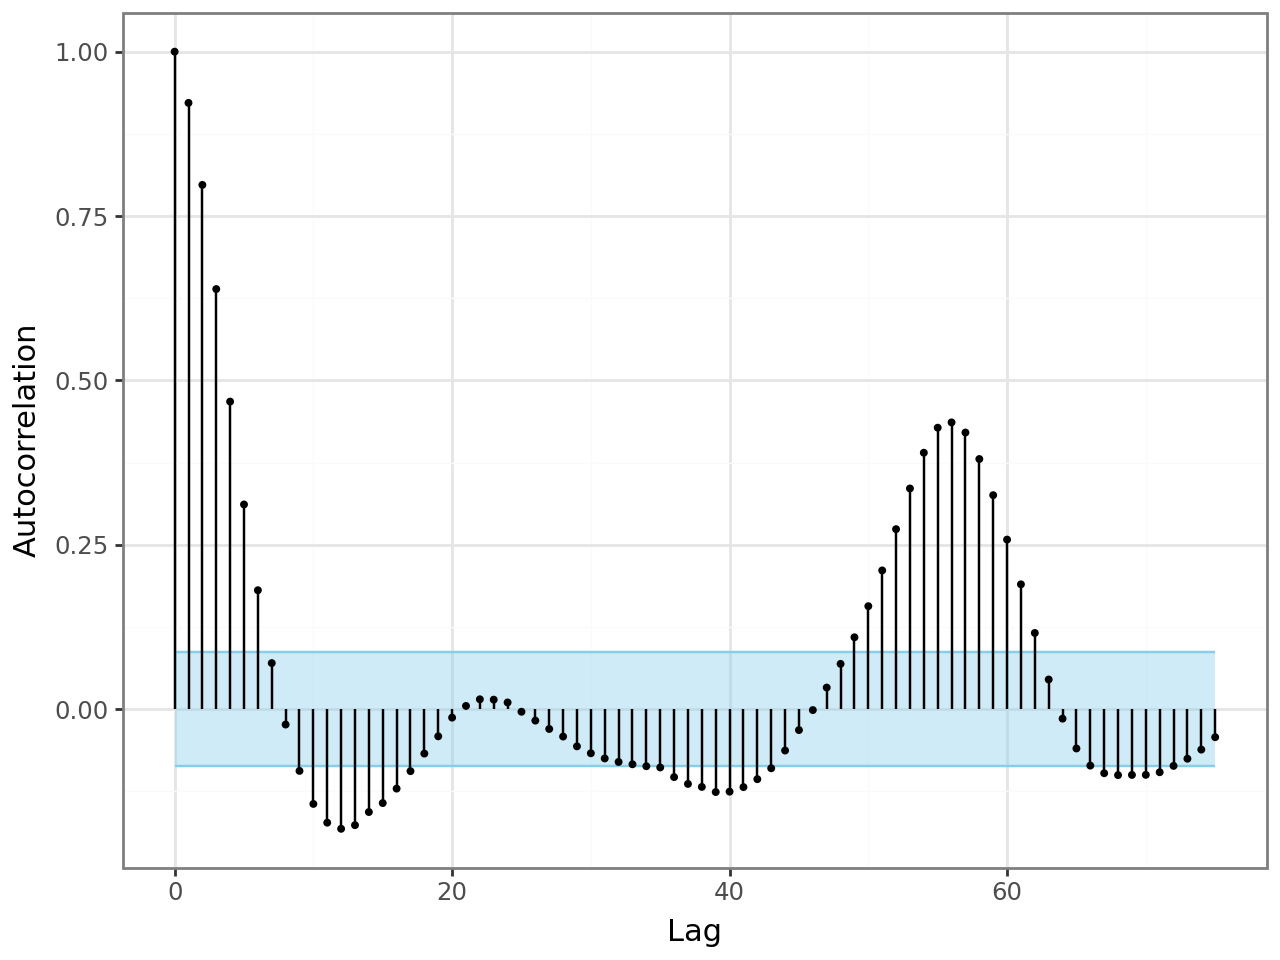

In [16]:
p = plot_acf(ts_deseasonalized.to_series(), bartlett=False)
p.show()

In [17]:
p.save(
    ROOT / "figures" / "acf_deseasonalized.pdf",
    width=160,
    height=80,
    units="mm",
    dpi=600,
    verbose=False,
)

# STL

In [18]:
from statsmodels.tsa.seasonal import STL

In [19]:
ts = targets["icosari-sari-DE"]

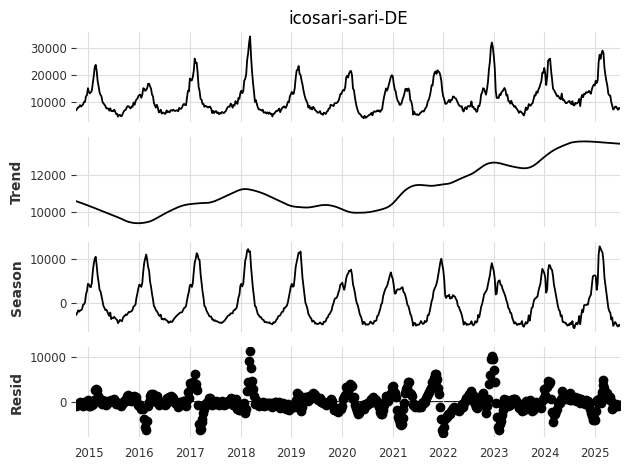

In [20]:
stl = STL(ts.to_series())
res = stl.fit()
fig = res.plot()

<Axes: xlabel='date'>

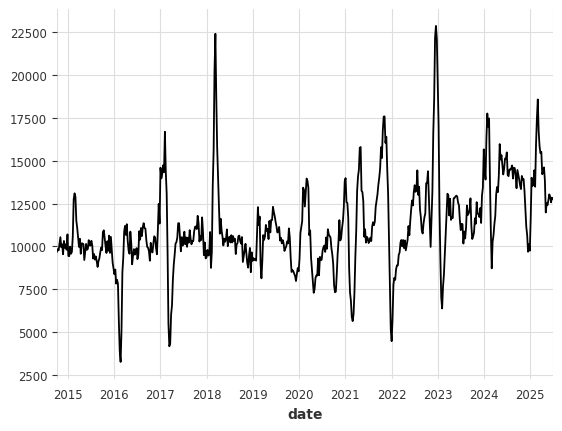

In [21]:
(res.observed - res.seasonal).plot()

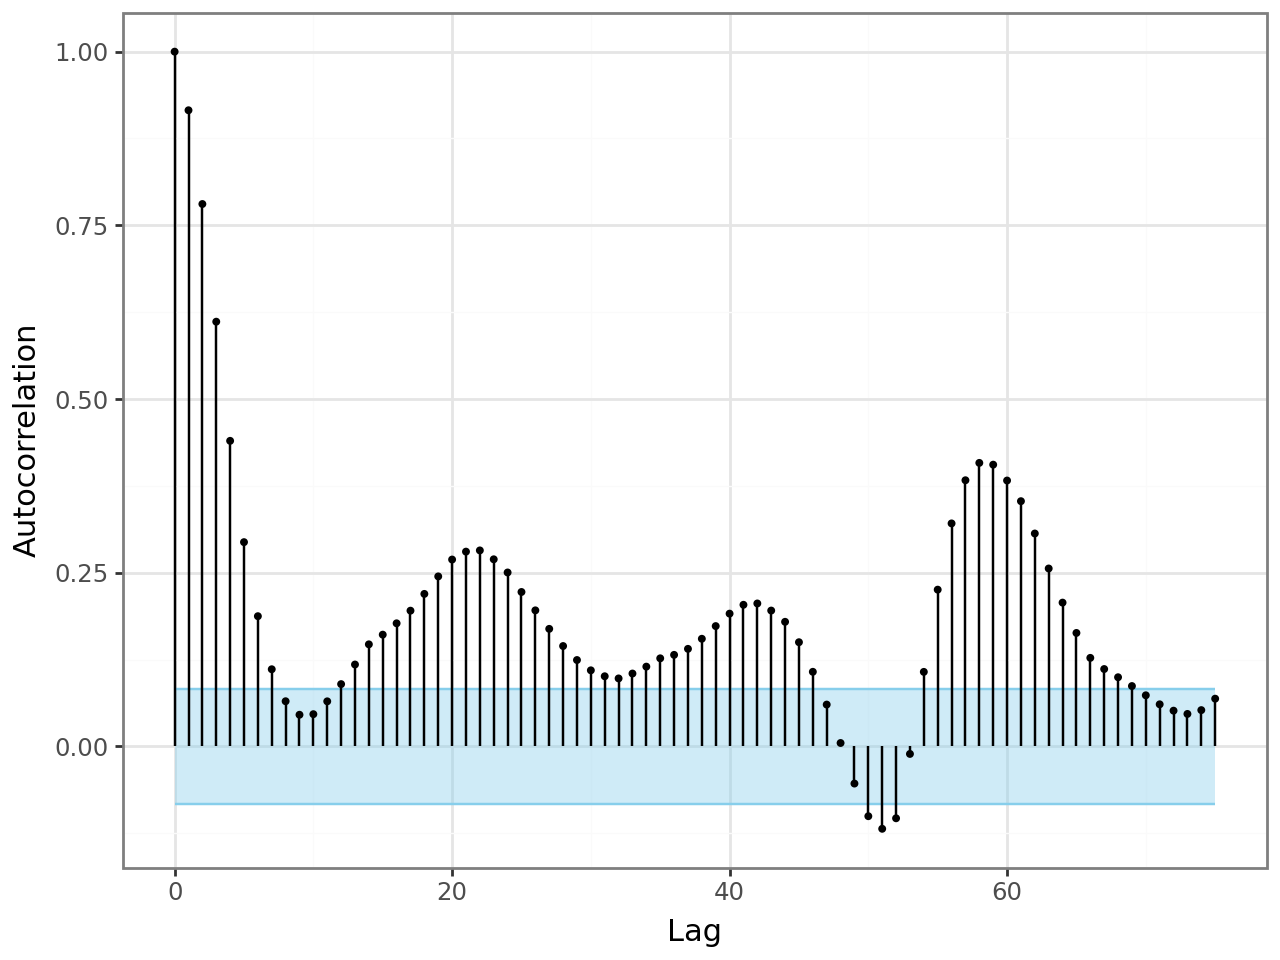

In [22]:
p = plot_acf((res.observed - res.seasonal), bartlett=False)
p.show()

In [23]:
p.save(
    ROOT / "figures" / "acf_deseasonalized_stl.pdf",
    width=160,
    height=80,
    units="mm",
    dpi=600,
    verbose=False,
)